In [2]:
import sys
sys.path[1] = '/home/sgururaj/src/flow_graphs/code/'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from collections import defaultdict, Counter
from collections import defaultdict as ddict
import itertools
import json
import os
import pickle
import random

import dill
from matplotlib import pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from transformers import AutoTokenizer
from tqdm.auto import tqdm
import wandb

from amr.inspection import get_type_paths_for_relation, gini_coefficient
from dataloading_utils import load_deprels
from evaluation import get_transfer_eval_filename

In [5]:
tqdm.pandas()

In [6]:
api = wandb.Api(timeout=30)

In [7]:
datasets = ["risec", "japflow", "mscorpus"]
FEWSHOT = 10

In [8]:
amr_content = {}
preprocessed_data = {}

for dataset in datasets:
    with open(f"data/{dataset}/amr_train.pkl", "rb") as f:
        amr_content[dataset] = pickle.load(f)

    with open(f"data/{dataset}/data_amr.dill", "rb") as f:
        preprocessed_data[dataset] = dill.load(f)
    

with open("data/amr_rel2id.json") as f:
    amr_rel2id = json.load(f)

amr_id2rel = {v:k for k, v in amr_rel2id.items()}

deprels = load_deprels("data/enh_dep_rel.txt")
dep_id2rel = {v:k for k, v in deprels.items()}

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

100%|██████████| 365/365 [00:00<00:00, 772802.10it/s]


In [9]:
dataset_to_paths_info = {}
unaggregated_paths_info = {}

reverse_map = {
    "amr_data": amr_id2rel,
    "dep_data": dep_id2rel
}

for dataset in datasets:
    dataset_to_paths_info[dataset] = {}
    unaggregated_paths_info[dataset] = {}
    for split in ["train", "dev", "test"]:
        label_to_paths = {
            "amr_data": defaultdict(list),
            "dep_data": defaultdict(list),
        }
        unaggregated_paths = defaultdict(list)
        for instance in preprocessed_data[dataset][split]["rels"]:
            for graph_type in ["amr_data", "dep_data"]:
                label = instance["label"]
                graph_data = instance[graph_type]
                type_paths = get_type_paths_for_relation(graph_data, reverse_map[graph_type])
                unaggregated_paths[graph_type].append((label, type_paths))
                label_to_paths[graph_type][label].extend(type_paths)
        dataset_to_paths_info[dataset][split] = label_to_paths
        unaggregated_paths_info[dataset][split] = unaggregated_paths


unigram_counters = {}

for dataset in datasets:
    unigram_counters[dataset] = {}
    for split in ["train", "dev", "test"]:
        unigram_counters[dataset][split] = {}
        for graph_type in ["dep_data", "amr_data"]:
            dataset_counters = {}
            unigram_counters[dataset][split][graph_type] = dataset_counters
            paths_info = dataset_to_paths_info[dataset][split][graph_type]
            for label, paths in paths_info.items():
                atomic_path_units = [tuple(path) for path in paths]
                unigram_path_units = list(itertools.chain(*paths))
                dataset_counters[label] = {"unigram": Counter(unigram_path_units), "atomic": Counter(atomic_path_units)}

In [1]:
unigram_counters["risec"]["train"]["amr_data"]["ArgM_INT"]["unigram"].most_common()

NameError: name 'unigram_counters' is not defined

In [39]:
[(label, d["unigram"][":location"], sum(d["unigram"].values())) for label, d in unigram_counters["japflow"]["train"]["amr_data"].items()]

[('targ', 214, 20520),
 ('dest', 375, 6504),
 ('other-mod', 469, 20501),
 ('f-eq', 35, 8399),
 ('agent', 38, 3253),
 ('t-eq', 136, 2186),
 ('v-tm', 3, 3005),
 ('t-comp', 304, 1774),
 ('a-eq', 49, 1308),
 ('f-part-of', 82, 5073),
 ('f-comp', 6, 1142),
 ('t-part-of', 30, 1558),
 ('f-set', 0, 219)]

In [16]:
print(gini_coefficient(unigram_counters["mscorpus"]["test"]["dep_data"]["Information_Of"]))
print(gini_coefficient(unigram_counters["mscorpus"]["test"]["amr_data"]["Information_Of"]))

0.6490434782608696
0.750621397792274


In [17]:
dataset_gini = {}
for dataset in datasets:
    dataset_gini[dataset] = {}
    for split in ["train", "dev", "test"]:
        dataset_gini[dataset][split] = {}
        for graph_type in ["dep_data", "amr_data"]:
            dataset_gini[dataset][split][graph_type] = {}
            for label, counter in unigram_counters[dataset][split][graph_type].items():
                dataset_gini[dataset][split][graph_type][label] = gini_coefficient(counter)

In [18]:
with open("dataset_gini_unigram.pkl", "wb") as f:
    pickle.dump(dataset_gini, f)

In [19]:
dataset_gini["risec"]["train"]["amr_data"]["ArgM_SIM"]

0.562962962962963

In [11]:
filters = {
    "state": "finished"
}

# from-scratch sweep
sweeps = ["masb7v5w", "v828yikt", "x6qwchbj", "sgk8b8c5", "009z7n7n", "masb7v5w"]


runs = []
for sweep_id in sweeps:
    sweep = api.sweep(f"flow-graphs-cmu/narrative-flow-simplified/{sweep_id}")
    runs.extend(sweep.runs)

In [45]:
df_dicts = []

for run in tqdm(runs):
    try:
        test_f1  = run.history(keys=["test_f1"], pandas=False)[0]["test_f1"]
        df_dicts.append({**run.config, "test_f1": test_f1, "name": run.name})
    except:
        continue

results_df = pd.DataFrame(df_dicts)

  0%|          | 0/252 [00:00<?, ?it/s]

In [46]:
results_df.shape

(244, 29)

In [47]:
df = results_df[(results_df["src_dataset"] == "mscorpus") & (results_df["tgt_dataset"] == "risec") & (results_df["fewshot"] == 10)][["name", "src_dataset", "tgt_dataset", "case", "fewshot", "seed", "test_f1", "train_dataset_instances"]]
df

,name,src_dataset,tgt_dataset,case,fewshot,seed,test_f1,train_dataset_instances
38,transfer-mscorpus-risec-fewshot_10-dep_residua...,mscorpus,risec,dep_residual,10,2,0.495249,"[1633, 2997, 2387, 1298, 253, 1844, 2834, 1105..."
39,transfer-mscorpus-risec-fewshot_10-dep_residua...,mscorpus,risec,dep_residual,10,1,0.524175,"[2250, 1291, 2258, 2721, 1459, 1998, 353, 2158..."
40,transfer-mscorpus-risec-fewshot_10-dep_residua...,mscorpus,risec,dep_residual,10,0,0.512471,"[3356, 1508, 1257, 668, 265, 82, 2129, 2647, 9..."
50,transfer-mscorpus-risec-fewshot_10-amr_residua...,mscorpus,risec,amr_residual,10,2,0.504181,"[1633, 2997, 2387, 1298, 253, 1844, 2834, 1105..."
51,transfer-mscorpus-risec-fewshot_10-amr_residua...,mscorpus,risec,amr_residual,10,1,0.498349,"[2250, 1291, 2258, 2721, 1459, 1998, 353, 2158..."
52,transfer-mscorpus-risec-fewshot_10-amr_residua...,mscorpus,risec,amr_residual,10,0,0.493979,"[3356, 1508, 1257, 668, 265, 82, 2129, 2647, 9..."
62,transfer-mscorpus-risec-fewshot_10-plaintext-c...,mscorpus,risec,plaintext,10,2,0.442507,"[1633, 2997, 2387, 1298, 253, 1844, 2834, 1105..."
64,transfer-mscorpus-risec-fewshot_10-plaintext-c...,mscorpus,risec,plaintext,10,0,0.461457,"[3356, 1508, 1257, 668, 265, 82, 2129, 2647, 9..."
65,transfer-mscorpus-risec-fewshot_10-plaintext-c...,mscorpus,risec,plaintext,10,1,0.466065,"[2250, 1291, 2258, 2721, 1459, 1998, 353, 2158..."


In [48]:
instance_indices = df.iloc[0]["train_dataset_instances"]
train_instances = [preprocessed_data["risec"]["train"]["rels"][idx] for idx in instance_indices]
type_paths = [unaggregated_paths_info["risec"]["train"][idx] for idx in instance_indices]

In [49]:
def get_per_label_performance_per_row(row):
    filename = get_transfer_eval_filename(src_dataset=row["src_dataset"], tgt_dataset=row["tgt_dataset"], fewshot=FEWSHOT, split="test", seed=row["seed"], case=row["case"])
    run_df = pd.read_csv(os.path.join("results", filename))
    labels = sorted(run_df["labels"].unique().tolist())
    p, r , f, s = precision_recall_fscore_support(y_true=run_df["labels"], y_pred=run_df["predictions"], labels=labels)
    f1_by_label = {label: f1 for label, f1 in zip(labels, f)}
    return f1_by_label

def get_path_counters_by_samples(dataset, sample_indices, graph_type):
    type_paths = [unaggregated_paths_info[dataset]["train"][graph_type][idx] for idx in sample_indices]
    paths_by_label = defaultdict(list)
    for label, paths in type_paths:
        paths_by_label[label].extend(paths)
    paths_by_label = dict(paths_by_label)

    counters_by_label = {label: Counter(itertools.chain(*paths)) for label, paths in paths_by_label.items()}
    return dict(sorted(counters_by_label.items()))

def get_gini_by_label(counters_by_label):
    return {label: gini_coefficient(counter) for label, counter in counters_by_label.items()}


def get_gini_by_label_for_row(row):
    if row["case"] == "plaintext":
        return None
    path_counters = get_path_counters_by_samples(row["tgt_dataset"], row["train_dataset_instances"], row["case"].replace("_residual", "_data"))
    gini_coefs = get_gini_by_label(path_counters)
    return gini_coefs

In [50]:
df["per_class_test_f1"] = df.apply(get_per_label_performance_per_row, axis=1)
df["per_class_gini"] = df.apply(get_gini_by_label_for_row, axis=1)

In [32]:
LABELS = ['ArgM_INT',
 'ArgM_LOC',
 'ArgM_MNR',
 'ArgM_PRP',
 'ArgM_SIM',
 'ArgM_TMP',
 'Arg_DIR',
 'Arg_GOL',
 'Arg_PAG',
 'Arg_PPT',
 'Arg_PRD']

f1s = []
gini_coefs = []
instance_labels = []
instance_label_index = []

f1s_by_label = defaultdict(list)
gini_by_label = defaultdict(list)
case_by_label = defaultdict(list)


def get_corresponding_plaintext_row(row, df):
    return df[(pd.DataFrame([df[thing] == row[thing] for thing in ["src_dataset", "tgt_dataset", "fewshot", "seed"]]).all()) & (df["case"] ==  "plaintext")].iloc[0]

    

for i, row in df[df["case"] != "plaintext"].iterrows():
    case = row["case"]
    for label, f1 in row["per_class_test_f1"].items():
        gini = row["per_class_gini"][label]
        baseline_f1 = get_corresponding_plaintext_row(row, df)["per_class_test_f1"][label]

        f1s.append(f1 - baseline_f1)
        gini_coefs.append(gini)
        instance_labels.append(label)

        f1s_by_label[label].append(f1)
        gini_by_label[label].append(gini)
        case_by_label[label].append(case)


        instance_label_index.append(LABELS.index(label))

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x=gini_coefs, y=f1s)


# for label in LABELS:
#     fig, ax = plt.subplots(figsize=(15,10))
#     ax.scatter(x=gini_by_label[label][:3], y=f1s_by_label[label][:3], c="green", label=case_by_label[label][0])
#     ax.scatter(x=gini_by_label[label][3:], y=f1s_by_label[label][3:], c="red", label=case_by_label[label][-1])
#     ax.legend()
#     ax.set_title(f"F1 vs Gini Coefficient for {label}")


NameError: name 'df' is not defined

In [18]:
row

name                       transfer-mscorpus-risec-fewshot_10-amr_residua...
src_dataset                                                         mscorpus
tgt_dataset                                                            risec
case                                                            amr_residual
fewshot                                                                   10
seed                                                                       0
test_f1                                                             0.493979
train_dataset_instances    [3356, 1508, 1257, 668, 265, 82, 2129, 2647, 9...
per_class_test_f1          {'ArgM_INT': 0.32, 'ArgM_LOC': 0.6806282722513...
per_class_gini             {'ArgM_INT': 0.34782608695652173, 'ArgM_LOC': ...
Name: 52, dtype: object

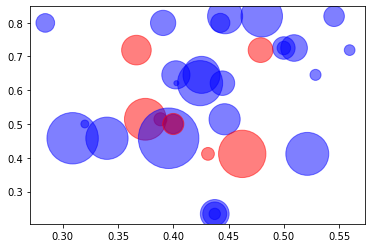

In [19]:

train_ginis = []
test_ginis = []
f1s = []

for label in LABELS:
    for i, row in df[df["case"] == "dep_residual"].iterrows():
        train_gini = row["per_class_gini"][label]
        f1 = row["per_class_test_f1"][label]
        baseline_f1 = get_corresponding_plaintext_row(row, df)["per_class_test_f1"][label]
        test_gini = dataset_gini[row["tgt_dataset"]]["test"][row["case"].replace("_residual", "_data")][label]
        train_ginis.append(train_gini)
        test_ginis.append(test_gini)
        f1s.append(f1 - baseline_f1)
fig, ax = plt.subplots()
ax.scatter(x=train_ginis, y=test_ginis, s=[np.abs(f1) * 10000 for f1 in f1s], c=["blue" if f1 > 0 else "red" for f1 in f1s], alpha=0.5)